In [1]:
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader, clean_na_values, select_symbol_id
from config import USER
import polars as pl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

Config initialisation

In [2]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEYS_S3s = [f"train.parquet/partition_id={i}/part-0.parquet" for i in range(10)]

In [3]:
data = pl.concat([reader.read_parquet(FILE_KEY_S3) for FILE_KEY_S3 in tqdm(FILE_KEYS_S3s)])
data.head()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,…,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,…,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,…,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,…,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,null,0.646086,null,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,null,…,1.253902,null,null,0.476195,null,-0.771732,2.843421,null,1.379815,0.411827,-1.36224,null,null,null,null,null,-0.948601,-0.136814,-0.447704,-1.141761,0.099631,-0.661928,null,null,3.678076,2.793581,2.61825,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.0,-3.57282,-1.089123,-5.0


# Processing

drop nans

In [4]:
data_clean_symb_1 = clean_na_values(select_symbol_id(data, id = 1), threshold = 0.1)

encode time_id

In [5]:
data_clean_symb_1 = data_clean_symb_1.with_columns([
    ((pl.col("time_id") - data["time_id"].min()) / (data["time_id"].max() - data["time_id"].min()) * (2 * np.pi)).alias("angle"),
    (((pl.col("time_id") - data["time_id"].min()) / (data["time_id"].max() - data["time_id"].min()) * (2 * np.pi)).sin()).alias("time_sin"),
    (((pl.col("time_id") - data["time_id"].min()) / (data["time_id"].max() - data["time_id"].min()) * (2 * np.pi)).cos()).alias("time_cos")
])

## Visualization

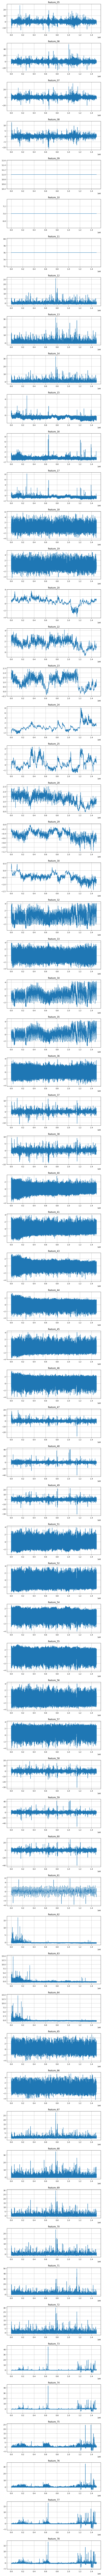

In [6]:
to_plot = data_clean_symb_1[[col for col in data_clean_symb_1.columns if "feature" in col]]

pdf = to_plot.to_pandas()
n_cols = pdf.shape[1]

# Subplots en colonne : n_cols lignes, 1 colonne
fig, axes = plt.subplots(n_cols, 1, figsize=(8, 3*n_cols), sharex=False)

# Gérer le cas n_cols == 1 (axes n'est pas une liste)
if n_cols == 1:
    axes = [axes]

for i, col in enumerate(pdf.columns):
    axes[i].plot(pdf[col].values)
    axes[i].set_title(col)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## Stationnarité

In [ ]:
to_plot = data_clean_symb_1[[col for col in data_clean_symb_1.columns if "feature" in col]]

pdf = to_plot.to_pandas()
n_cols = pdf.shape[1]

# Subplots : n_cols lignes, 2 colonnes (gauche = série, droite = diff)
fig, axes = plt.subplots(n_cols, 2, figsize=(12, 3*n_cols), sharex=False)

# Si une seule série, axes n'est pas un tableau 2D → on le force
if n_cols == 1:
    axes = np.array([axes])

for i, col in enumerate(pdf.columns):
    series = pdf[col].values
    diff = np.diff(series)

    # Plot de la série originale (gauche)
    axes[i, 0].plot(series)
    axes[i, 0].set_title(f"{col} (original)")
    axes[i, 0].grid(True)

    # Plot de la différence (droite)
    axes[i, 1].plot(diff)
    axes[i, 1].set_title(f"{col} (diff)")
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()
